# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'
import numpy as np
import pickle as pkl

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

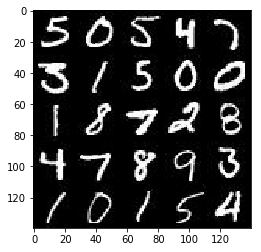

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

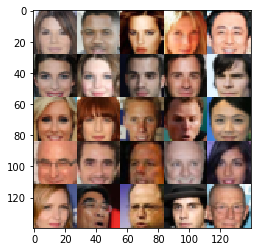

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name = 'real_input')
    z_input = tf.placeholder(tf.float32, (None, z_dim), name='z_input')
    learning_rate = tf.placeholder(tf.float32, None, name='learning_rate')
    
    return real_input, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope("discriminator", reuse = reuse):
        ### Images: batch x 28 x 28 x n_channels
        h1 = tf.layers.conv2d(images, 64, 5, strides = 2, padding = 'same', activation = None)
        relu1 = tf.nn.relu(h1)
        # Relu1 has shape 14x14x64
        # Note: in the first layer we use DCGan paper advise and don't use batch normalization.
        
        h2 = tf.layers.conv2d(relu1, 128, 5, strides = 2, padding = 'same', activation = None)
        b2 = tf.layers.batch_normalization(h2, training = True)
        relu2 = tf.nn.relu(b2)
        # Layer output shape = 7 x 7 x 128
        
        h3 = tf.layers.conv2d(relu2, 256, 5, strides = 2, padding = 'same', activation = None)
        b3 = tf.layers.batch_normalization(h3, training = True)
        relu3 = tf.nn.relu(b3)
        # output shape = 4 x 4 x 256
        
        flatten = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flatten, 1)
        output = tf.nn.sigmoid(logits)
        
    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    with tf.variable_scope('generator', reuse = not is_train):
        # First layer
        x1 = tf.layers.dense(z, (7*7*256), activation = None)
        x1 = tf.reshape(x1, (-1, 7,7,256))
        x1 = tf.layers.batch_normalization(x1, training = is_train)
        x1 = tf.nn.relu(x1)
        
        # Second layer
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides = 2, padding = 'same', activation = None)
        x2 = tf.layers.batch_normalization(x2, training = is_train)
        x2 = tf.nn.relu(x2)
        
        # Third layer
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides = 2, padding = 'same', activation = None)
        x3 = tf.layers.batch_normalization(x3, training = is_train)
        x3 = tf.nn.relu(x3)
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides = 1, padding = 'same')
        out = tf.nn.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [28]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    
    # Generate fake images
    input_fake = generator(input_z, out_channel_dim, is_train = True)

    # Compute Discriminator output for Real and Fake Images
    d_real_output, d_real_logits = discriminator(input_real, reuse = False) # with reuse = False we start a new variable scope
    d_fake_output, d_fake_logits = discriminator(input_fake, reuse = True) # but for the fake images we actually want to re-use the same scope

    # Discriminator Loss
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits = d_real_logits, labels =tf.ones_like(d_real_output))
    )
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits = d_fake_logits, labels = tf.zeros_like(d_fake_output))
    )

    d_loss = d_loss_fake + d_loss_real

    # Generator loss
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits = d_fake_logits, labels = tf.ones_like(d_fake_output))
    )
    
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [29]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
        # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [30]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [31]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    # Building the network.
    # First of all reset the TF Graph
    tf.reset_default_graph()
    
    # Create the inputs
    image_width = data_shape[1]
    image_height = data_shape[2]
    image_channels = data_shape[3]
    
    real_input, z_input, lr_placeholder = model_inputs(image_width, image_height, image_channels, z_dim)
    
    # Create loss functions
    out_channel_dim = data_shape[3]
    d_loss, g_loss = model_loss(real_input, z_input, out_channel_dim)
    
    # Create loss optimizers
    d_opt, g_opt = model_opt(d_loss, g_loss, lr_placeholder, beta1)
    
    
    saver = tf.train.Saver()
    step = 0
    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                step += 1
                #batch_z = np.random.normal(0,0.25, size = (batch_size, z_dim))
                batch_z = np.random.uniform(-1,1, size = (batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={real_input: batch_images, z_input: batch_z, lr_placeholder:learning_rate})
                _ = sess.run(g_opt, feed_dict={real_input: batch_images, z_input: batch_z, lr_placeholder:learning_rate})
            
                # Print and save losses at end of the first batch and then every 10th batch
                if (step % 10 == 0 or step == 1):
                        # At the end of each epoch, get the losses and print them out
                        train_loss_d = d_loss.eval({z_input: batch_z, real_input: batch_images})
                        train_loss_g = g_loss.eval({z_input: batch_z, real_input: batch_images})

                        print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                              "Discriminator Loss: {:.4f}...".format(train_loss_d),
                              "Generator Loss: {:.4f}".format(train_loss_g))
                
                # Show generated images at end of the first batch and then every 100th batch
                if (step % 100 == 0 or step == 1):
                    show_generator_output(sess, 25, z_input, out_channel_dim, data_image_mode)
                
    #saver.save(sess, './checkpoints/generator.ckpt')

            
                                        

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.4076... Generator Loss: 0.3849


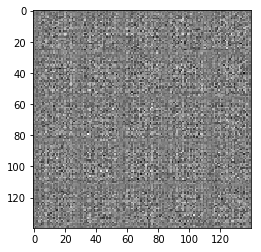

Epoch 1/2... Discriminator Loss: 0.4833... Generator Loss: 1.4323
Epoch 1/2... Discriminator Loss: 0.4029... Generator Loss: 1.7988
Epoch 1/2... Discriminator Loss: 0.2645... Generator Loss: 2.0839
Epoch 1/2... Discriminator Loss: 0.2475... Generator Loss: 2.4820
Epoch 1/2... Discriminator Loss: 0.4311... Generator Loss: 1.4752
Epoch 1/2... Discriminator Loss: 0.4422... Generator Loss: 1.5063
Epoch 1/2... Discriminator Loss: 0.3629... Generator Loss: 1.9549
Epoch 1/2... Discriminator Loss: 0.4445... Generator Loss: 2.8686
Epoch 1/2... Discriminator Loss: 0.4441... Generator Loss: 1.5396
Epoch 1/2... Discriminator Loss: 0.3752... Generator Loss: 1.7072


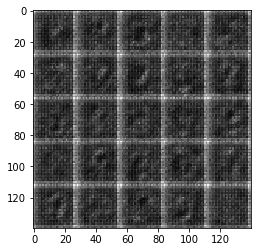

Epoch 1/2... Discriminator Loss: 0.5668... Generator Loss: 1.0817
Epoch 1/2... Discriminator Loss: 0.2547... Generator Loss: 2.4320
Epoch 1/2... Discriminator Loss: 0.2536... Generator Loss: 2.1409
Epoch 1/2... Discriminator Loss: 0.2151... Generator Loss: 2.3945
Epoch 1/2... Discriminator Loss: 0.1314... Generator Loss: 2.7611
Epoch 1/2... Discriminator Loss: 0.1210... Generator Loss: 3.2258
Epoch 1/2... Discriminator Loss: 0.0838... Generator Loss: 3.4075
Epoch 1/2... Discriminator Loss: 0.0580... Generator Loss: 3.3940
Epoch 1/2... Discriminator Loss: 0.0782... Generator Loss: 3.2907
Epoch 1/2... Discriminator Loss: 0.0361... Generator Loss: 4.4015


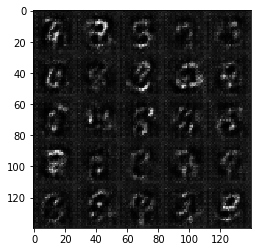

Epoch 1/2... Discriminator Loss: 0.0604... Generator Loss: 3.5490
Epoch 1/2... Discriminator Loss: 0.0587... Generator Loss: 3.4468
Epoch 1/2... Discriminator Loss: 0.0708... Generator Loss: 3.0375
Epoch 1/2... Discriminator Loss: 0.0470... Generator Loss: 3.5978
Epoch 1/2... Discriminator Loss: 0.3861... Generator Loss: 1.3505
Epoch 1/2... Discriminator Loss: 0.3718... Generator Loss: 2.2595
Epoch 1/2... Discriminator Loss: 0.1393... Generator Loss: 3.0127
Epoch 1/2... Discriminator Loss: 0.1415... Generator Loss: 2.3414
Epoch 1/2... Discriminator Loss: 0.0960... Generator Loss: 4.0107
Epoch 1/2... Discriminator Loss: 0.0453... Generator Loss: 3.8306


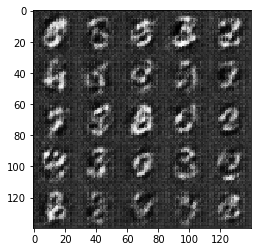

Epoch 1/2... Discriminator Loss: 0.1886... Generator Loss: 9.6797
Epoch 1/2... Discriminator Loss: 0.3752... Generator Loss: 6.3814
Epoch 1/2... Discriminator Loss: 0.0565... Generator Loss: 4.9884
Epoch 1/2... Discriminator Loss: 0.0257... Generator Loss: 5.9122
Epoch 1/2... Discriminator Loss: 0.1681... Generator Loss: 2.6406
Epoch 1/2... Discriminator Loss: 0.0495... Generator Loss: 5.2744
Epoch 1/2... Discriminator Loss: 0.0950... Generator Loss: 9.5506
Epoch 1/2... Discriminator Loss: 0.0504... Generator Loss: 6.8059
Epoch 1/2... Discriminator Loss: 0.1229... Generator Loss: 3.1086
Epoch 1/2... Discriminator Loss: 0.2101... Generator Loss: 2.1053


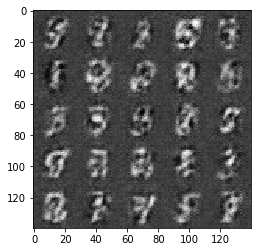

Epoch 1/2... Discriminator Loss: 0.0689... Generator Loss: 4.1036
Epoch 1/2... Discriminator Loss: 0.0371... Generator Loss: 4.5949
Epoch 1/2... Discriminator Loss: 0.3199... Generator Loss: 1.7490
Epoch 1/2... Discriminator Loss: 0.1093... Generator Loss: 3.2060
Epoch 1/2... Discriminator Loss: 0.1385... Generator Loss: 2.6273
Epoch 1/2... Discriminator Loss: 0.0495... Generator Loss: 5.5985
Epoch 2/2... Discriminator Loss: 0.5183... Generator Loss: 1.1729
Epoch 2/2... Discriminator Loss: 0.1022... Generator Loss: 3.9569
Epoch 2/2... Discriminator Loss: 0.1428... Generator Loss: 2.4550
Epoch 2/2... Discriminator Loss: 0.0433... Generator Loss: 5.3653


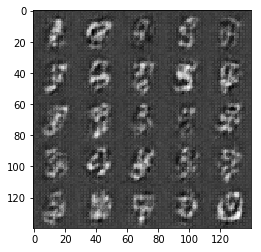

Epoch 2/2... Discriminator Loss: 0.1951... Generator Loss: 2.1203
Epoch 2/2... Discriminator Loss: 0.0610... Generator Loss: 5.7779
Epoch 2/2... Discriminator Loss: 0.0888... Generator Loss: 3.4427
Epoch 2/2... Discriminator Loss: 0.0603... Generator Loss: 3.6723
Epoch 2/2... Discriminator Loss: 0.0421... Generator Loss: 4.9481
Epoch 2/2... Discriminator Loss: 0.0890... Generator Loss: 4.4244
Epoch 2/2... Discriminator Loss: 0.1101... Generator Loss: 3.8105
Epoch 2/2... Discriminator Loss: 0.1417... Generator Loss: 2.6654
Epoch 2/2... Discriminator Loss: 0.1564... Generator Loss: 3.9669
Epoch 2/2... Discriminator Loss: 0.0728... Generator Loss: 3.7501


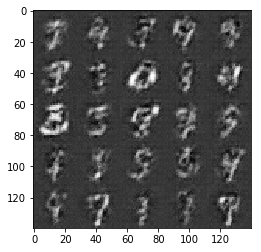

Epoch 2/2... Discriminator Loss: 0.0664... Generator Loss: 3.8730
Epoch 2/2... Discriminator Loss: 1.4300... Generator Loss: 0.4266
Epoch 2/2... Discriminator Loss: 0.1314... Generator Loss: 3.0977
Epoch 2/2... Discriminator Loss: 0.1416... Generator Loss: 2.9520
Epoch 2/2... Discriminator Loss: 0.1175... Generator Loss: 3.0097
Epoch 2/2... Discriminator Loss: 0.1140... Generator Loss: 3.0517
Epoch 2/2... Discriminator Loss: 0.0974... Generator Loss: 3.1455
Epoch 2/2... Discriminator Loss: 0.1151... Generator Loss: 2.9699
Epoch 2/2... Discriminator Loss: 0.0694... Generator Loss: 3.8403
Epoch 2/2... Discriminator Loss: 0.0459... Generator Loss: 4.2217


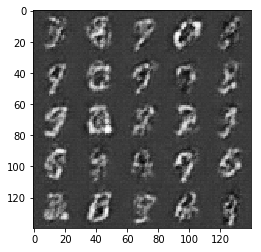

Epoch 2/2... Discriminator Loss: 0.0870... Generator Loss: 3.1832
Epoch 2/2... Discriminator Loss: 0.0731... Generator Loss: 3.5936
Epoch 2/2... Discriminator Loss: 0.0642... Generator Loss: 3.8414
Epoch 2/2... Discriminator Loss: 0.0700... Generator Loss: 3.8785
Epoch 2/2... Discriminator Loss: 0.0853... Generator Loss: 3.2817
Epoch 2/2... Discriminator Loss: 0.0960... Generator Loss: 3.2387
Epoch 2/2... Discriminator Loss: 0.0848... Generator Loss: 3.3354
Epoch 2/2... Discriminator Loss: 0.0861... Generator Loss: 3.4374
Epoch 2/2... Discriminator Loss: 0.0680... Generator Loss: 3.6262
Epoch 2/2... Discriminator Loss: 0.1046... Generator Loss: 3.0720


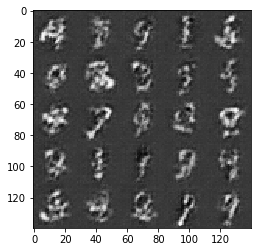

Epoch 2/2... Discriminator Loss: 0.0680... Generator Loss: 3.8461
Epoch 2/2... Discriminator Loss: 0.0552... Generator Loss: 4.2710
Epoch 2/2... Discriminator Loss: 0.0602... Generator Loss: 3.8214
Epoch 2/2... Discriminator Loss: 0.0583... Generator Loss: 4.4270
Epoch 2/2... Discriminator Loss: 0.0441... Generator Loss: 4.5285
Epoch 2/2... Discriminator Loss: 0.0378... Generator Loss: 4.4951
Epoch 2/2... Discriminator Loss: 0.0502... Generator Loss: 4.6500
Epoch 2/2... Discriminator Loss: 0.0388... Generator Loss: 5.0508
Epoch 2/2... Discriminator Loss: 0.0535... Generator Loss: 5.0792
Epoch 2/2... Discriminator Loss: 0.0258... Generator Loss: 4.8850


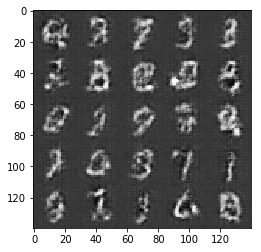

Epoch 2/2... Discriminator Loss: 6.5217... Generator Loss: 0.0044
Epoch 2/2... Discriminator Loss: 0.2863... Generator Loss: 2.2988
Epoch 2/2... Discriminator Loss: 0.2452... Generator Loss: 2.3758


IndexError: list index out of range

In [34]:
batch_size = 128
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 2.6442... Generator Loss: 0.0915


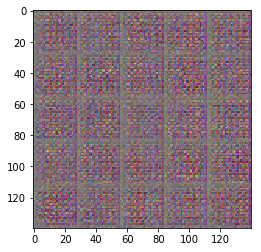

Epoch 1/1... Discriminator Loss: 0.3260... Generator Loss: 1.9968
Epoch 1/1... Discriminator Loss: 0.3033... Generator Loss: 2.0166
Epoch 1/1... Discriminator Loss: 0.3600... Generator Loss: 1.4825
Epoch 1/1... Discriminator Loss: 1.6183... Generator Loss: 0.2904
Epoch 1/1... Discriminator Loss: 0.4962... Generator Loss: 1.8374
Epoch 1/1... Discriminator Loss: 0.5198... Generator Loss: 4.9645
Epoch 1/1... Discriminator Loss: 0.2292... Generator Loss: 2.1854
Epoch 1/1... Discriminator Loss: 0.2036... Generator Loss: 3.2211
Epoch 1/1... Discriminator Loss: 0.2404... Generator Loss: 1.8939
Epoch 1/1... Discriminator Loss: 0.2816... Generator Loss: 1.7344


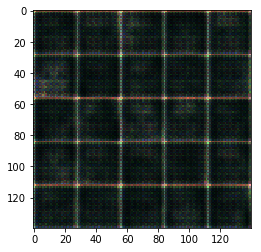

Epoch 1/1... Discriminator Loss: 0.0606... Generator Loss: 3.9785
Epoch 1/1... Discriminator Loss: 0.0648... Generator Loss: 5.9101
Epoch 1/1... Discriminator Loss: 0.1704... Generator Loss: 2.4919
Epoch 1/1... Discriminator Loss: 0.0885... Generator Loss: 3.2069
Epoch 1/1... Discriminator Loss: 0.0134... Generator Loss: 5.1193
Epoch 1/1... Discriminator Loss: 0.1186... Generator Loss: 3.6526
Epoch 1/1... Discriminator Loss: 0.5636... Generator Loss: 7.1587
Epoch 1/1... Discriminator Loss: 0.3739... Generator Loss: 1.4037
Epoch 1/1... Discriminator Loss: 0.0013... Generator Loss: 8.7069
Epoch 1/1... Discriminator Loss: 0.1697... Generator Loss: 2.3343


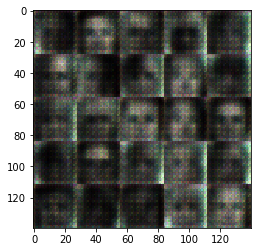

Epoch 1/1... Discriminator Loss: 0.0058... Generator Loss: 10.4709
Epoch 1/1... Discriminator Loss: 1.1732... Generator Loss: 0.4995
Epoch 1/1... Discriminator Loss: 0.0112... Generator Loss: 7.4013
Epoch 1/1... Discriminator Loss: 0.1186... Generator Loss: 3.4171
Epoch 1/1... Discriminator Loss: 0.1219... Generator Loss: 2.5837
Epoch 1/1... Discriminator Loss: 0.0667... Generator Loss: 3.4126
Epoch 1/1... Discriminator Loss: 0.0576... Generator Loss: 13.5902
Epoch 1/1... Discriminator Loss: 0.0056... Generator Loss: 7.8463
Epoch 1/1... Discriminator Loss: 0.0097... Generator Loss: 7.7693
Epoch 1/1... Discriminator Loss: 0.4024... Generator Loss: 3.6911


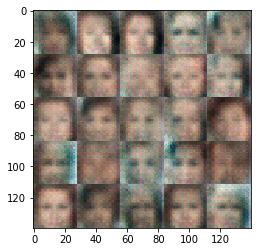

Epoch 1/1... Discriminator Loss: 0.6863... Generator Loss: 0.8930
Epoch 1/1... Discriminator Loss: 0.0887... Generator Loss: 4.8685
Epoch 1/1... Discriminator Loss: 0.0640... Generator Loss: 5.2226
Epoch 1/1... Discriminator Loss: 0.0211... Generator Loss: 7.1560
Epoch 1/1... Discriminator Loss: 0.2290... Generator Loss: 1.9158
Epoch 1/1... Discriminator Loss: 0.9855... Generator Loss: 0.6126
Epoch 1/1... Discriminator Loss: 1.0921... Generator Loss: 0.5095
Epoch 1/1... Discriminator Loss: 0.0591... Generator Loss: 6.4277
Epoch 1/1... Discriminator Loss: 0.1035... Generator Loss: 2.7982
Epoch 1/1... Discriminator Loss: 0.0376... Generator Loss: 10.5126


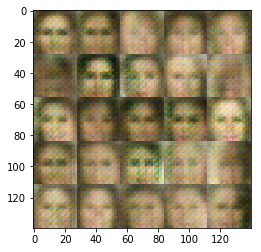

Epoch 1/1... Discriminator Loss: 0.0274... Generator Loss: 9.4135
Epoch 1/1... Discriminator Loss: 0.0272... Generator Loss: 13.9099
Epoch 1/1... Discriminator Loss: 0.0416... Generator Loss: 4.1364
Epoch 1/1... Discriminator Loss: 0.3566... Generator Loss: 1.4635
Epoch 1/1... Discriminator Loss: 0.0403... Generator Loss: 4.2116
Epoch 1/1... Discriminator Loss: 0.1531... Generator Loss: 2.1486
Epoch 1/1... Discriminator Loss: 0.0052... Generator Loss: 8.1821
Epoch 1/1... Discriminator Loss: 0.0115... Generator Loss: 6.9798
Epoch 1/1... Discriminator Loss: 0.1294... Generator Loss: 2.7955
Epoch 1/1... Discriminator Loss: 0.4643... Generator Loss: 6.9211


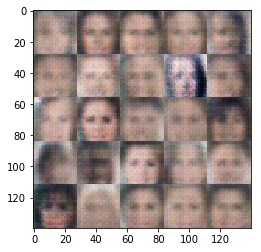

Epoch 1/1... Discriminator Loss: 0.2128... Generator Loss: 4.4739
Epoch 1/1... Discriminator Loss: 0.0294... Generator Loss: 11.9517
Epoch 1/1... Discriminator Loss: 0.0879... Generator Loss: 2.8155
Epoch 1/1... Discriminator Loss: 0.0147... Generator Loss: 6.3712
Epoch 1/1... Discriminator Loss: 0.0878... Generator Loss: 4.2073
Epoch 1/1... Discriminator Loss: 0.1014... Generator Loss: 7.4394
Epoch 1/1... Discriminator Loss: 0.4442... Generator Loss: 1.2908
Epoch 1/1... Discriminator Loss: 0.0793... Generator Loss: 3.3234
Epoch 1/1... Discriminator Loss: 1.5543... Generator Loss: 0.3160
Epoch 1/1... Discriminator Loss: 1.5826... Generator Loss: 0.3072


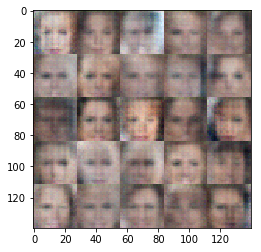

Epoch 1/1... Discriminator Loss: 0.2660... Generator Loss: 2.1291
Epoch 1/1... Discriminator Loss: 0.8905... Generator Loss: 0.6791
Epoch 1/1... Discriminator Loss: 0.2064... Generator Loss: 2.9435
Epoch 1/1... Discriminator Loss: 0.1331... Generator Loss: 13.4189
Epoch 1/1... Discriminator Loss: 0.0084... Generator Loss: 7.0353
Epoch 1/1... Discriminator Loss: 1.5113... Generator Loss: 9.6803
Epoch 1/1... Discriminator Loss: 0.2557... Generator Loss: 11.7777
Epoch 1/1... Discriminator Loss: 0.5745... Generator Loss: 8.0074
Epoch 1/1... Discriminator Loss: 0.0478... Generator Loss: 4.5035
Epoch 1/1... Discriminator Loss: 0.0840... Generator Loss: 8.8343


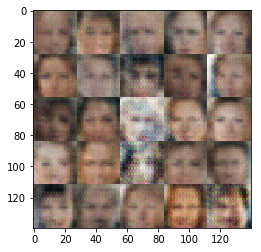

Epoch 1/1... Discriminator Loss: 0.0673... Generator Loss: 9.3511
Epoch 1/1... Discriminator Loss: 0.1465... Generator Loss: 2.5692
Epoch 1/1... Discriminator Loss: 0.0525... Generator Loss: 7.1268
Epoch 1/1... Discriminator Loss: 0.2016... Generator Loss: 9.6396
Epoch 1/1... Discriminator Loss: 0.3437... Generator Loss: 1.9165
Epoch 1/1... Discriminator Loss: 0.5858... Generator Loss: 3.1593
Epoch 1/1... Discriminator Loss: 0.1034... Generator Loss: 5.8619
Epoch 1/1... Discriminator Loss: 0.9724... Generator Loss: 0.6698
Epoch 1/1... Discriminator Loss: 0.0676... Generator Loss: 4.6583
Epoch 1/1... Discriminator Loss: 0.1380... Generator Loss: 2.7564


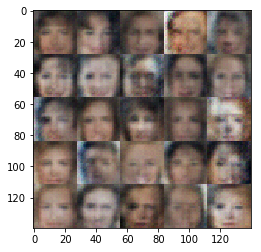

Epoch 1/1... Discriminator Loss: 0.1901... Generator Loss: 2.4191
Epoch 1/1... Discriminator Loss: 0.0890... Generator Loss: 4.5535
Epoch 1/1... Discriminator Loss: 0.0831... Generator Loss: 2.8555
Epoch 1/1... Discriminator Loss: 0.3560... Generator Loss: 1.5817
Epoch 1/1... Discriminator Loss: 0.0496... Generator Loss: 4.4965
Epoch 1/1... Discriminator Loss: 0.2331... Generator Loss: 2.4142
Epoch 1/1... Discriminator Loss: 0.1891... Generator Loss: 7.3521
Epoch 1/1... Discriminator Loss: 0.2043... Generator Loss: 2.3533
Epoch 1/1... Discriminator Loss: 0.0209... Generator Loss: 6.3519
Epoch 1/1... Discriminator Loss: 0.0248... Generator Loss: 8.9308


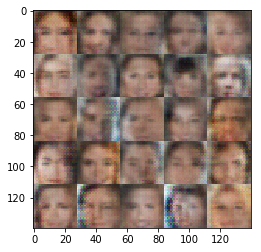

Epoch 1/1... Discriminator Loss: 0.6843... Generator Loss: 0.9019
Epoch 1/1... Discriminator Loss: 0.0389... Generator Loss: 4.4822
Epoch 1/1... Discriminator Loss: 0.1620... Generator Loss: 10.5192
Epoch 1/1... Discriminator Loss: 0.0131... Generator Loss: 8.9875
Epoch 1/1... Discriminator Loss: 0.0790... Generator Loss: 5.5478
Epoch 1/1... Discriminator Loss: 0.7382... Generator Loss: 1.0429
Epoch 1/1... Discriminator Loss: 0.5139... Generator Loss: 2.9753
Epoch 1/1... Discriminator Loss: 0.2647... Generator Loss: 2.1211
Epoch 1/1... Discriminator Loss: 1.5361... Generator Loss: 6.7082
Epoch 1/1... Discriminator Loss: 0.1840... Generator Loss: 2.2344


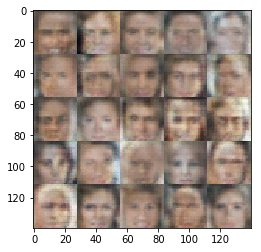

Epoch 1/1... Discriminator Loss: 0.8718... Generator Loss: 2.2115
Epoch 1/1... Discriminator Loss: 0.0634... Generator Loss: 4.8321
Epoch 1/1... Discriminator Loss: 0.0831... Generator Loss: 3.3280
Epoch 1/1... Discriminator Loss: 0.0629... Generator Loss: 6.3939
Epoch 1/1... Discriminator Loss: 0.9783... Generator Loss: 0.7337
Epoch 1/1... Discriminator Loss: 0.3140... Generator Loss: 1.7318
Epoch 1/1... Discriminator Loss: 0.5936... Generator Loss: 1.0468
Epoch 1/1... Discriminator Loss: 0.0734... Generator Loss: 3.4434
Epoch 1/1... Discriminator Loss: 0.3405... Generator Loss: 1.4773
Epoch 1/1... Discriminator Loss: 0.0448... Generator Loss: 6.0268


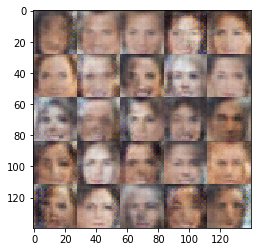

Epoch 1/1... Discriminator Loss: 0.2102... Generator Loss: 2.1434
Epoch 1/1... Discriminator Loss: 0.3358... Generator Loss: 1.4858
Epoch 1/1... Discriminator Loss: 1.4049... Generator Loss: 0.3680
Epoch 1/1... Discriminator Loss: 0.9613... Generator Loss: 0.8479
Epoch 1/1... Discriminator Loss: 0.4616... Generator Loss: 3.7975
Epoch 1/1... Discriminator Loss: 0.3087... Generator Loss: 1.7642
Epoch 1/1... Discriminator Loss: 1.2384... Generator Loss: 4.4044
Epoch 1/1... Discriminator Loss: 0.3404... Generator Loss: 3.9485
Epoch 1/1... Discriminator Loss: 0.3489... Generator Loss: 1.6059
Epoch 1/1... Discriminator Loss: 0.0942... Generator Loss: 3.9299


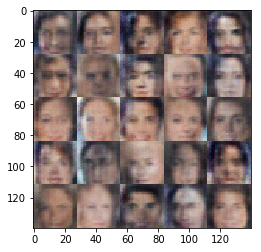

Epoch 1/1... Discriminator Loss: 0.3207... Generator Loss: 1.5679
Epoch 1/1... Discriminator Loss: 0.0371... Generator Loss: 7.1729
Epoch 1/1... Discriminator Loss: 0.2792... Generator Loss: 1.6820
Epoch 1/1... Discriminator Loss: 2.7771... Generator Loss: 9.0085
Epoch 1/1... Discriminator Loss: 1.0861... Generator Loss: 1.5924
Epoch 1/1... Discriminator Loss: 1.0628... Generator Loss: 0.5754
Epoch 1/1... Discriminator Loss: 0.0999... Generator Loss: 6.4994
Epoch 1/1... Discriminator Loss: 0.2924... Generator Loss: 4.1660
Epoch 1/1... Discriminator Loss: 0.4611... Generator Loss: 7.2536
Epoch 1/1... Discriminator Loss: 0.2535... Generator Loss: 2.0722


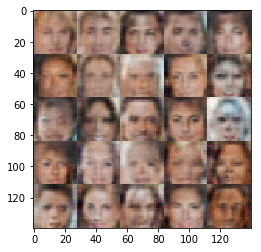

Epoch 1/1... Discriminator Loss: 0.8553... Generator Loss: 0.6650
Epoch 1/1... Discriminator Loss: 0.0867... Generator Loss: 2.9955
Epoch 1/1... Discriminator Loss: 0.2648... Generator Loss: 2.9375
Epoch 1/1... Discriminator Loss: 0.2177... Generator Loss: 1.9626
Epoch 1/1... Discriminator Loss: 0.0111... Generator Loss: 7.6642
Epoch 1/1... Discriminator Loss: 0.0790... Generator Loss: 3.7551
Epoch 1/1... Discriminator Loss: 0.6670... Generator Loss: 1.0242
Epoch 1/1... Discriminator Loss: 1.3681... Generator Loss: 0.7407
Epoch 1/1... Discriminator Loss: 1.0050... Generator Loss: 0.9479
Epoch 1/1... Discriminator Loss: 0.8309... Generator Loss: 1.0720


Epoch 1/1... Discriminator Loss: 1.2574... Generator Loss: 0.4496
Epoch 1/1... Discriminator Loss: 0.2169... Generator Loss: 4.0233
Epoch 1/1... Discriminator Loss: 0.2650... Generator Loss: 2.3480
Epoch 1/1... Discriminator Loss: 0.9259... Generator Loss: 4.1158
Epoch 1/1... Discriminator Loss: 0.0537... Generator Loss: 5.4074
Epoch 1/1... Discriminator Loss: 1.1169... Generator Loss: 4.3942
Epoch 1/1... Discriminator Loss: 0.1394... Generator Loss: 4.7425
Epoch 1/1... Discriminator Loss: 1.0819... Generator Loss: 0.5259
Epoch 1/1... Discriminator Loss: 0.0676... Generator Loss: 4.7434
Epoch 1/1... Discriminator Loss: 0.1129... Generator Loss: 5.6474


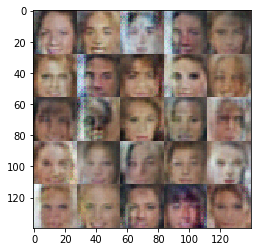

Epoch 1/1... Discriminator Loss: 0.0292... Generator Loss: 6.4947
Epoch 1/1... Discriminator Loss: 0.6810... Generator Loss: 0.9420
Epoch 1/1... Discriminator Loss: 0.7003... Generator Loss: 0.8512
Epoch 1/1... Discriminator Loss: 0.3126... Generator Loss: 6.5199
Epoch 1/1... Discriminator Loss: 0.1047... Generator Loss: 4.7095
Epoch 1/1... Discriminator Loss: 0.3992... Generator Loss: 1.3359
Epoch 1/1... Discriminator Loss: 0.0287... Generator Loss: 5.5043
Epoch 1/1... Discriminator Loss: 0.1174... Generator Loss: 2.5508


IndexError: list index out of range

In [35]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.